In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder

In [7]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.9 MB/s eta 0:00:00


## CARGA DEL DATASET

In [9]:
# Carga del dataset
data = pd.read_csv("/content/datasetfinal (2).csv",low_memory=False)
print(f"Dimensiones iniciales: {data.shape}")
# Mostrar las primeras filas del DataFrame

#Eliminar Periodo
data = data.drop(columns=["Periodo"])

print(data.head())
print(data.dtypes)


Dimensiones iniciales: (1241, 17)
  Comunidad Autonoma  Actividad      Censo  Criminalidad  GastoHogares  \
0       01 Andalucía       58.6  2058278.0       11092.5      27695.68   
1       01 Andalucía       58.6  2058278.0       11092.5      27695.68   
2       01 Andalucía       58.6  2058278.0       11092.5      27695.68   
3       01 Andalucía       58.6  2058278.0       11092.5      27695.68   
4       01 Andalucía       58.6  2058278.0       11092.5      27695.68   

   GastoProteccionAmbiental  Hipotecas  IngresosMedios     IPC  \
0                30083672.0    85994.0         10686.0  95.104   
1                30083672.0    85994.0         10686.0  95.104   
2                30083672.0    85994.0         10686.0  73.207   
3                30083672.0   905392.0         10686.0  75.097   
4                30083672.0  1722680.0         10686.0  77.420   

     TipoVivienda     IPV       NumHabitaciones  NumHogares    PIB  \
0  Vivienda nueva  109.46  7 o más habitaciones      1

### NORMALIZACION DE LAS VARIABLES NUMERICAS Y CODIFICACION DE LAS VARIABLES CATEGORICAS

In [10]:
# Normalizar los datos
# Seleccionar columnas numéricas
numerical_cols = data.select_dtypes(include=[np.number]).columns

# Aplicar la normalización
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

target = 'IPV'
X = data.drop(columns=[target])
y = data[target]

### CODIFICACION VARIABLES CATEGORICAS

Las variables categóricas se codifican utilizando TargetEncoder. Esta función asigna números enteros a las diferentes clases, sin necesidad de crear una nueva columna por cada clase.

In [11]:
from category_encoders import TargetEncoder

# Definir columnas categóricas
categorical_cols=['Comunidad Autonoma', 'TipoVivienda', 'NumHabitaciones']

# Inicializar el codificador
target_enc = TargetEncoder(cols=categorical_cols)

# Ajustar y transformar los datos
X[categorical_cols] = target_enc.fit_transform(X[categorical_cols],y)


In [ ]:
print(X)

      Comunidad Autonoma  Actividad     Censo  Criminalidad  GastoHogares  \
0              -0.102805   0.132962 -0.072935     -0.310325     -0.170883   
1              -0.102805   0.132962 -0.072935     -0.310325     -0.170883   
2              -0.102805   0.132962 -0.072935     -0.310325     -0.170883   
3              -0.102805   0.132962 -0.072935     -0.310325     -0.170883   
4              -0.102805   0.132962 -0.072935     -0.310325     -0.170883   
...                  ...        ...       ...           ...           ...   
1236            0.138123   0.132962 -2.608915     -0.789319     -0.500939   
1237            0.138123   0.589682 -2.608663     -0.782006      0.321104   
1238            0.138123   0.589682 -2.608663     -0.782006      0.321104   
1239            0.138123   0.459191 -2.604776     -0.310325      1.241895   
1240            0.138123   0.132962 -0.072935     -0.310325     -0.170883   

      GastoProteccionAmbiental  Hipotecas  IngresosMedios       IPC  \
0   

In [12]:
# Dividir datos en train (80%) y un conjunto de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resultados de la división
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (992, 15)
Tamaño del conjunto de prueba: (249, 15)


## EVALUACIÓN Y ENTRENAMIENTO DE LOS MODELOS

En esta matriz se irán guardando los valores de las métricas resultantes para cada uno de los modelos y poder compararlas al final

In [13]:
results_matrix = []

### ÁRBOLES DE REGRESIÓN

In [14]:
decision_tree = DecisionTreeRegressor(random_state=50)
param_grid = {
    'max_depth': [None, 5, 10, 15, 25],            # Profundidad máxima del árbol; None permite crecer sin límite
    'min_samples_split': [2, 5, 10, 20, 30],         # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 6, 10],            # Número mínimo de muestras que debe tener un nodo hoja
    'max_features': [None, 'sqrt', 'log2'],          # Número de características a considerar para la mejor división
    'max_leaf_nodes': [None, 10, 20, 30, 40],        # Máximo número de nodos hoja en el árbol
}

# GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Mejor modelo
best_decision_tree = grid_search.best_estimator_
print("Mejores parámetros para Decision Tree:", grid_search.best_params_)

Mejores parámetros para Decision Tree: {'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


Resultados para Decision Tree:
Test RMSE: 0.4422, Test MAE: 0.1963, Test MSE: 0.1956, Test R^2: 0.8083


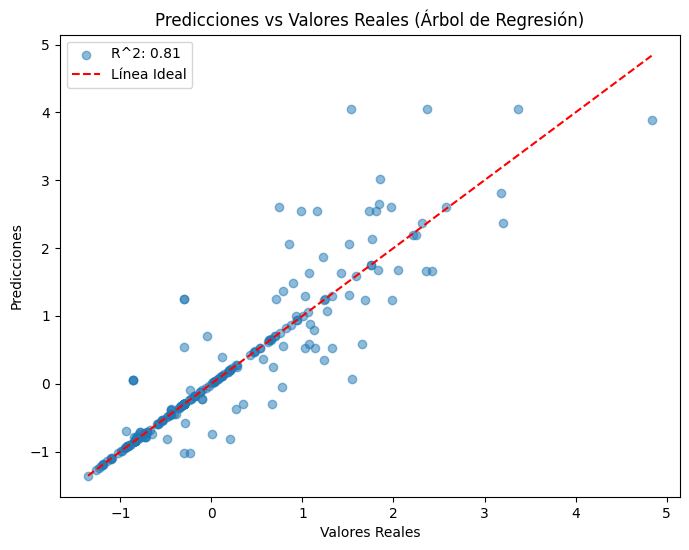

In [15]:
# Evaluación en el conjunto de prueba
y_test_pred = best_decision_tree.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Guardar los resultados en la matriz
results_matrix.append({
    'Model': 'ÁRBOL DE DECISIÓN',
    'R^2': test_r2,
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MSE': test_mse
})

print(f"Resultados para Decision Tree:")
print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}")

# Representar las predicciones en función de los datos reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label=f"R^2: {test_r2:.2f}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Línea Ideal")  # Línea de referencia
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales (Árbol de Regresión)")
plt.legend()
plt.show()

### RANDOM FOREST

In [16]:
random_forest = RandomForestRegressor(random_state=50)
param_grid = {
    'n_estimators': [150,200,300,500],
    'max_depth': [10,15,20,40]
}

# GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_random_forest = grid_search.best_estimator_
print("Mejores parámetros para Random Forest:", grid_search.best_params_)

Mejores parámetros para Random Forest: {'max_depth': 15, 'n_estimators': 150}


Resultados para Random Forest:
Test RMSE: 0.3206, Test MAE: 0.1552, Test MSE: 0.1028, Test R^2: 0.8993


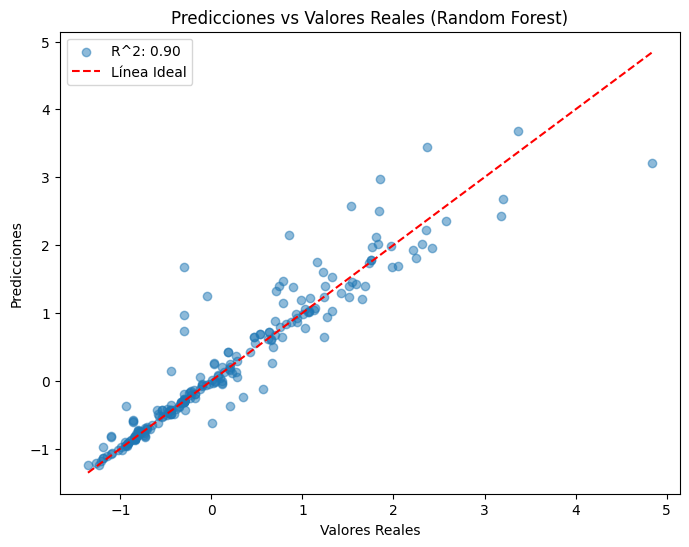

In [17]:
# Evaluación en el conjunto de prueba
y_test_pred = best_random_forest.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Guardar los resultados en la matriz
results_matrix.append({
    'Model': 'RANDOM FOREST',
    'R^2': test_r2,
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MSE': test_mse
})

print(f"Resultados para Random Forest:")
print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}")

# Representar las predicciones en función de los datos reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label=f"R^2: {test_r2:.2f}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Línea Ideal")  # Línea de referencia
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales (Random Forest)")
plt.legend()
plt.show()

### XGBOOST

In [18]:
xgboost = XGBRegressor(random_state=50)
param_grid = {
    'n_estimators': [100,125,150,300],
    'max_depth': [10,15,20],
    'learning_rate': [0.01, 0.1, 0.5],
}

# GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(xgboost, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_xgboost = grid_search.best_estimator_
print("Mejores parámetros para XGBoost:", grid_search.best_params_)

Mejores parámetros para XGBoost: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 125}


Resultados para XGBoost:
Test RMSE: 0.2772, Test MAE: 0.1291, Test MSE: 0.0768, Test R^2: 0.9247


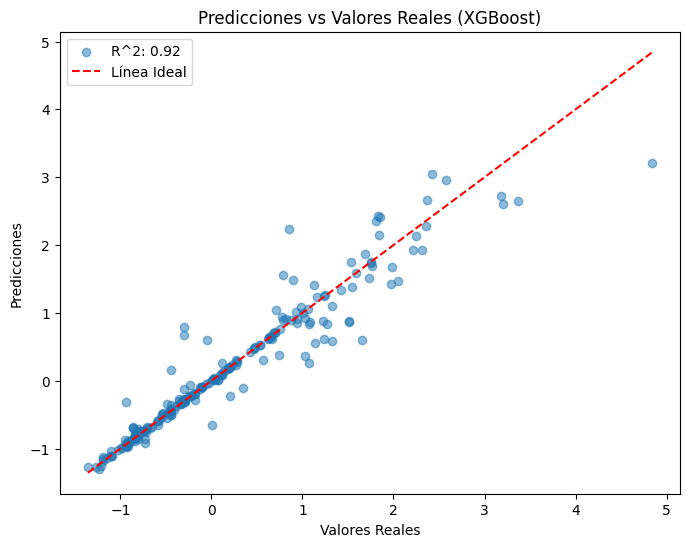

In [19]:
# Evaluación en el conjunto de prueba
y_test_pred = best_xgboost.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Guardar los resultados en la matriz
results_matrix.append({
    'Model': 'XGBOOST',
    'R^2': test_r2,
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MSE': test_mse
})

print(f"Resultados para XGBoost:")
print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}")

# Representar las predicciones en función de los datos reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label=f"R^2: {test_r2:.2f}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Línea Ideal")  # Línea de referencia
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales (XGBoost)")
plt.legend()
plt.show()

## RESULTADOS

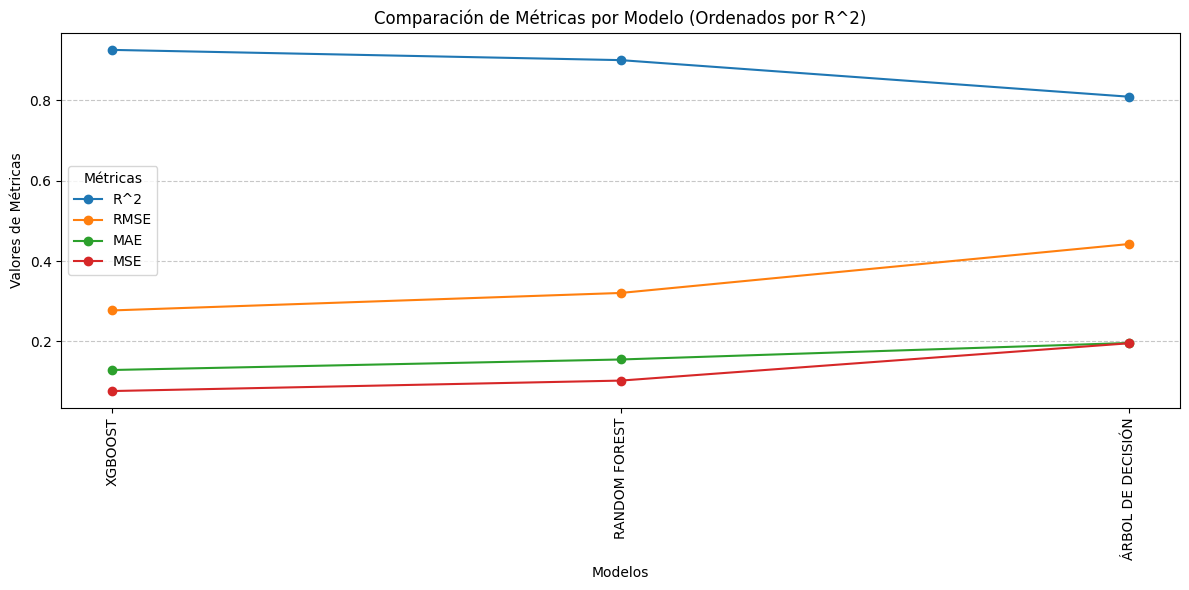

In [20]:
# Convertir a DataFrame
df_results = pd.DataFrame(results_matrix)

# Ordenar por R^2 de mayor a menor
df_sorted = df_results.sort_values(by='R^2', ascending=False)

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
metrics = ['R^2', 'RMSE', 'MAE', 'MSE']

# Graficar cada métrica
for metric in metrics:
    plt.plot(df_sorted['Model'], df_sorted[metric], marker='o', label=metric)

# Personalización del gráfico
plt.title('Comparación de Métricas por Modelo (Ordenados por R^2)')
plt.xlabel('Modelos')
plt.ylabel('Valores de Métricas')
plt.xticks(rotation=90)  # Rotar nombres de los modelos para mejor legibilidad
plt.legend(title='Métricas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [21]:
print(results_matrix)

[{'Model': 'ÁRBOL DE DECISIÓN', 'R^2': 0.808304398697252, 'RMSE': np.float64(0.4422440304684576), 'MAE': 0.19632815422841002, 'MSE': 0.1955797824849861}, {'Model': 'RANDOM FOREST', 'R^2': 0.8992699926688568, 'RMSE': np.float64(0.32057919822996184), 'MAE': 0.1552431010755715, 'MSE': 0.10277102233776518}, {'Model': 'XGBOOST', 'R^2': 0.9247005030318114, 'RMSE': np.float64(0.2771736513743968), 'MAE': 0.12911512043846401, 'MSE': 0.07682523301621567}]


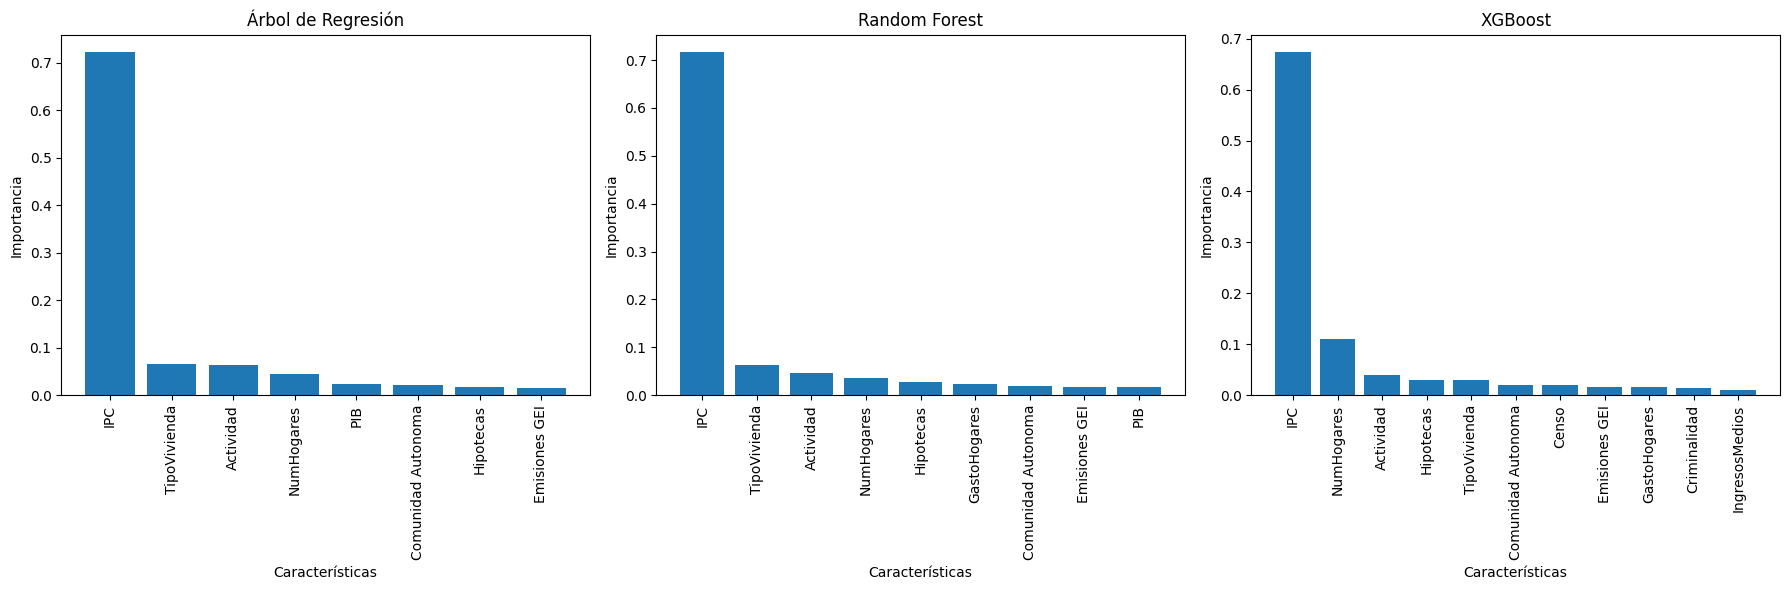

In [22]:
def plot_filtered_feature_importances(model, feature_names, ax, threshold=0.01, title=""):
    # Obtener las importancias de las características
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Ordenar de mayor a menor importancia

    # Filtrar las características con importancia mayor al umbral
    filtered_indices = [i for i in indices if importances[i] > threshold]

    # Nombres e importancias filtradas
    filtered_names = [feature_names[i] for i in filtered_indices]
    filtered_importances = importances[filtered_indices]

    # Graficar en el eje dado
    ax.bar(range(len(filtered_importances)), filtered_importances, align="center")
    ax.set_xticks(range(len(filtered_importances)))
    ax.set_xticklabels(filtered_names, rotation=90)
    ax.set_title(title)
    ax.set_xlabel("Características")
    ax.set_ylabel("Importancia")

# Obtener el nombre de las características
feature_names = data.columns

# Crear subplots para tres modelos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

# Graficar para Árbol de Decisión
plot_filtered_feature_importances(best_decision_tree, feature_names, axes[0], threshold=0.01, title="Árbol de Regresión")

# Graficar para Random Forest
plot_filtered_feature_importances(best_random_forest, feature_names, axes[1], threshold=0.01, title="Random Forest")

# Graficar para XGBoost
plot_filtered_feature_importances(best_xgboost, feature_names, axes[2], threshold=0.01, title="XGBoost")

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()